In [1]:
from sklearn.cluster import KMeans

import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [23]:
df['lon']

<xarray.DataArray 'lon' (lon: 7200)> Size: 58kB
array([0.000e+00, 1.000e+00, 2.000e+00, ..., 7.197e+03, 7.198e+03, 7.199e+03])
Coordinates:
  * lon      (lon) float64 58kB 0.0 1.0 2.0 ... 7.197e+03 7.198e+03 7.199e+03

TypeError: No numeric data to plot.

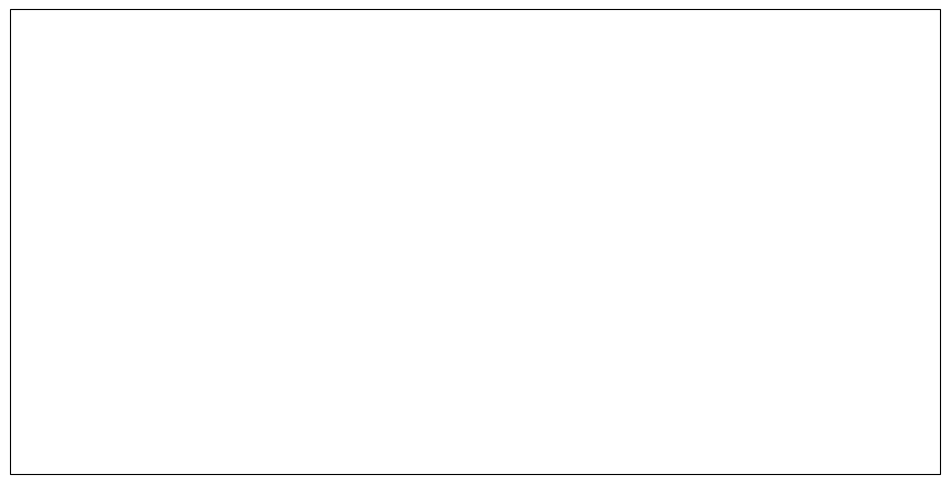

In [21]:
landmask = '/glade/work/maryamao/JEDI/urban_properties_modified.nc'
# Open the dataset
df = xr.open_dataset(landmask)

df['lon'] = df['lon'].astype(float)
df['lat'] = df['lat'].astype(float)

# Define CONUS bounds
lon_min, lon_max = -125, -66.5
lat_min, lat_max = 24, 49.5

# Subset the data
df_conus = df.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

# Extract the subset variables
pct_urban = df_conus['PCT_URBAN']

# Sum across the classes (assuming the class dimension is 'class_dim')
pct_urban_sum = pct_urban.sum(dim='density_class')

# Plot the result
plt.figure(figsize=(12, 8))

# Create a map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
pct_urban_sum.plot(
    ax=ax,
    cmap='viridis',  # Choose a color map
    cbar_kwargs={'label': 'Sum of PCT_URBAN classes'}
)

# Add country boundaries and coastlines
ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='black')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Limit the extent to CONUS
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add title and labels
plt.title('Sum of Urban Percentage Classes (CONUS)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()



In [13]:
pct_urban_sum

<xarray.DataArray 'PCT_URBAN' (lat: 3600, lon: 7200)> Size: 207MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Dimensions without coordinates: lat, lon

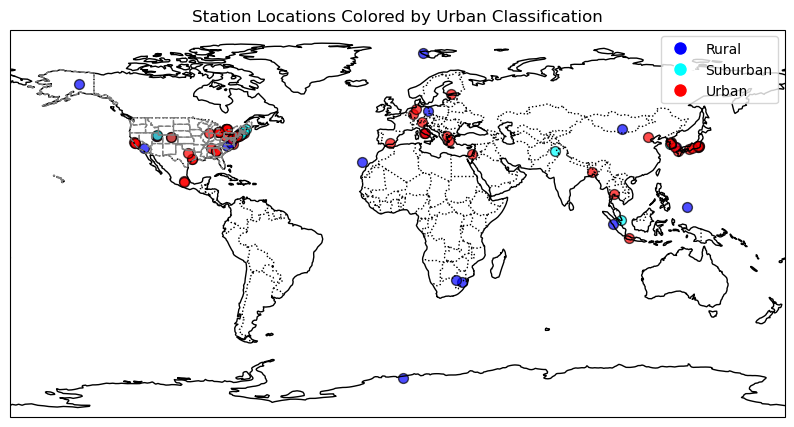

In [9]:
landmask = '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/gao_oneill_urban/historical/urban_properties_GaoOneil_05deg_ThreeClass_2020_cdf5_c20220910.nc'
df = xr.open_dataset(landmask)
df['lat'] = df['LAT']
df['lon'] = df['LON']

results = []


pandora_loc = pd.read_csv('/glade/work/maryamao/JEDI/pandora_coord_global.csv')
stn_lats = pandora_loc['Latitude'].values
stn_lons = pandora_loc['Longitude'].values
stn_names = pandora_loc['File']
for (slat,slon,sname) in zip(stn_lats, stn_lons,stn_names):
    pct_urb = df['PCT_URBAN'].sel(lat=slat,lon=slon,method='nearest').values
    pct_urb_sum = pct_urb.sum()

    if pct_urb_sum <= 10:
        urb_class = 1 # Rural
    elif 10 < pct_urb_sum <= 30:
        urb_class = 2 # Suburban
    elif pct_urb_sum >30:
        urb_class = 3 # urban
    
    results.append({
        'File': sname,
        'lat': slat,
        'lon': slon,
        'urb_class': urb_class,
        'pct_urb_sum': pct_urb_sum,
        'pct_urb': pct_urb,
    })
    
results_df = pd.DataFrame(results)
results_df.to_csv('/glade/work/maryamao/JEDI/pandora_coord_urb.csv', index=False)

# Define the latitude and longitude bounds
lat_min, lat_max = -90, 90
lon_min, lon_max = -180, 180

# Create a map with colored stations based on their class
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add geographic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='--', edgecolor='gray')

# Define colors for each class
colors = {1: 'blue', 2: 'cyan', 3: 'red'}

# Plot each station with a color based on its class
for _, row in results_df.iterrows():
    plt.scatter(
        row['lon'],
        row['lat'],
        color=colors[row['urb_class']],
        label=row['urb_class'],
        s=50,  # Marker size
        transform=ccrs.PlateCarree(),
        edgecolor='k',  # Black edge for better visibility
        alpha=0.7  # Transparency
    )

# Create a legend for the classes
# Only add one legend entry per class
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=10, label='Rural'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[2], markersize=10, label='Suburban'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[3], markersize=10, label='Urban')
]
ax.legend(handles=handles, loc='upper right')

states = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',  # Adjust scale: '10m', '50m', or '110m'
    facecolor='none'
)
ax.add_feature(states, edgecolor='gray', linewidth=0.5)

# Set the extent of the map to focus on the CONUS region
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add a title to the map
plt.title('Station Locations Colored by Urban Classification')

# Save the map to a file
output_map_path = '/glade/work/maryamao/JEDI/station_location_global_map.png'
plt.savefig(output_map_path, dpi=300, bbox_inches='tight')
plt.show()


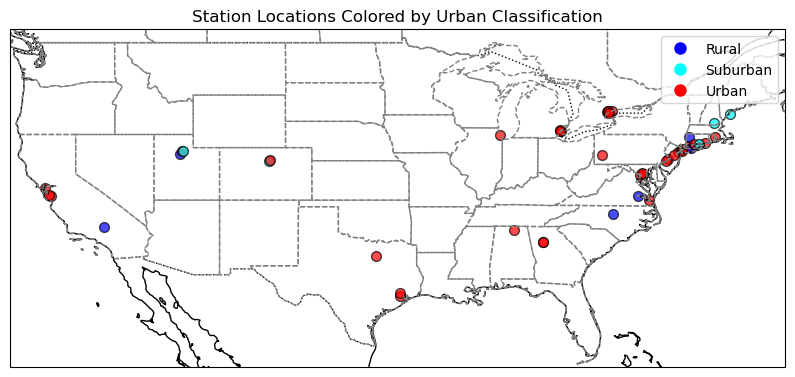

In [70]:
# 43.781, -79.468 
df['PCT_URBAN'].sel(lat=43.781,lon=-79.468,method='nearest').values # toronto

array([ 0.        , 26.37453071, 52.74906143])

In [71]:
df['PCT_URBAN'].sel(lat=43.561,lon=-70.2073,method='nearest').values # Maine

array([0.        , 1.17684887, 9.21858709])

In [72]:
df['PCT_URBAN'].sel(lat=19.07,lon=72.877,method='nearest').values # india

array([ 5.30216522, 87.48572608,  2.65108261])

In [3]:
df = pd.read_csv('/glade/work/maryamao/OBS/PANDORA/total_no2/sites_out_nooutlier.csv')

Index(['File', 'Latitude', 'Longitude', 'Mean', 'STD'], dtype='object')

In [20]:
X = df[['Mean', 'STD']].values

X.shape

(121, 2)

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define the number of clusters (3 for this example).
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit the model.
kmeans.fit(X)

# Get cluster labels.
labels = kmeans.labels_

# Add the labels to the DataFrame for easier analysis.
df['Cluster'] = labels

# Print the DataFrame with the assigned clusters.
print(df.head())

                                         File  Latitude  Longitude       Mean  \
0          Pandora198s1_Kobe_L2_rnvs3p1-8.txt   34.7190   135.2900  12.632850   
1  Pandora77s1_Singapore-NUS_L2_rnvs3p1-8.txt    1.2990   103.7710  18.993019   
2      Pandora25s1_HoustonTX_L2_rnvs3p1-8.txt   29.7200   -95.3400  10.190010   
3  Pandora208s1_Windsor-West_L2_rnvs3p1-8.txt   42.2929   -83.0731   8.314514   
4   Pandora174s1_FairbanksAK_L2_rnvs3p1-8.txt   64.8594  -147.8499   5.412277   

        STD  Cluster  
0  8.040125        1  
1  8.454299        1  
2  4.118814        0  
3  2.992504        0  
4  1.462705        0  


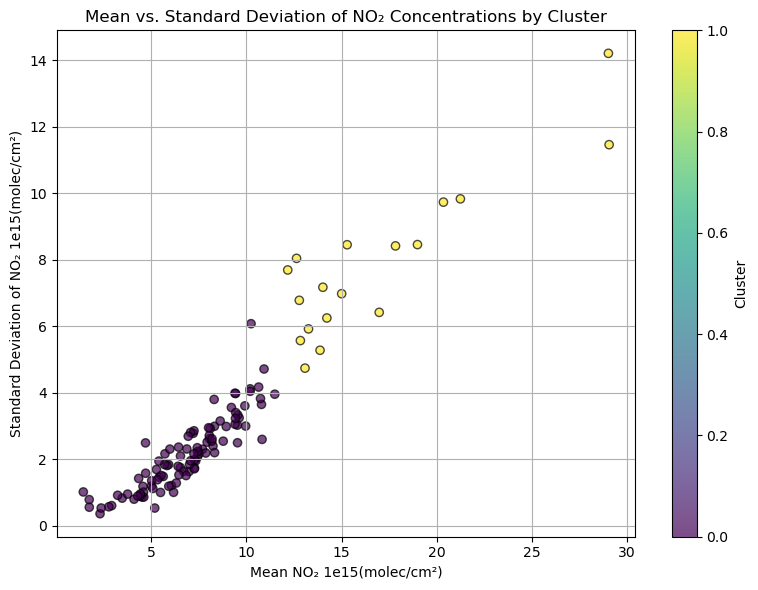

In [30]:
import matplotlib.pyplot as plt

# Define a colormap for the clusters
cmap = plt.get_cmap('viridis')

# Create the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['Mean'], df['STD'], c=df['Cluster'], cmap=cmap, alpha=0.7, edgecolor='k')

# Add labels and title
plt.title('Mean vs. Standard Deviation of NO₂ Concentrations by Cluster')
plt.xlabel('Mean NO₂ 1e15(molec/cm²)')
plt.ylabel('Standard Deviation of NO₂ 1e15(molec/cm²)')

# Add a color bar to indicate cluster numbers
plt.colorbar(scatter, label='Cluster')

# Show grid for better readability
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


In [31]:
df.to_csv('sites_clustered.csv', index=False)

In [4]:
from netCDF4 import Dataset

# Open the original NetCDF file
original_file = "/glade/work/maryamao/JEDI/urban_properties_GaoOneil_05deg_ThreeClass_2020_cdf5_c20220910.nc"
new_file = "/glade/work/maryamao/JEDI/urban_properties_modified.nc"

dimensions_to_keep = {"lat", "lon", "density_class"}

with Dataset(original_file, "r") as src, Dataset(new_file, "w") as dst:
    # Copy global attributes
    dst.setncatts({attr: src.getncattr(attr) for attr in src.ncattrs()})

    for name, dimension in src.dimensions.items():
        if name in dimensions_to_keep:
            dst.createDimension(
                name, (len(dimension) if not dimension.isunlimited() else None)
            )
    
    # Copy variables except the one to delete
    variable_to_keep = "PCT_URBAN"
    for name, variable in src.variables.items():
        if name == variable_to_keep:
            new_var = dst.createVariable(name, variable.datatype, variable.dimensions)
            new_var.setncatts({attr: variable.getncattr(attr) for attr in variable.ncattrs()})
            new_var[:] = variable[:]

print(f"Variable '{variable_to_keep}' kept. New file saved as {new_file}.")


Variable 'PCT_URBAN' kept. New file saved as /glade/work/maryamao/JEDI/urban_properties_modified.nc.


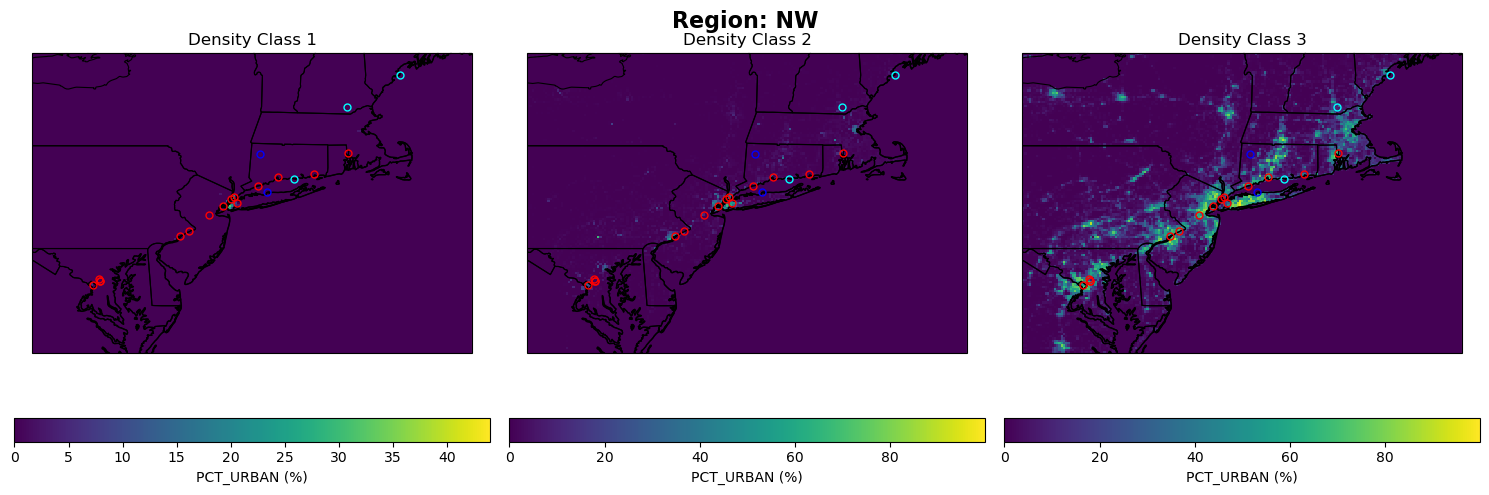

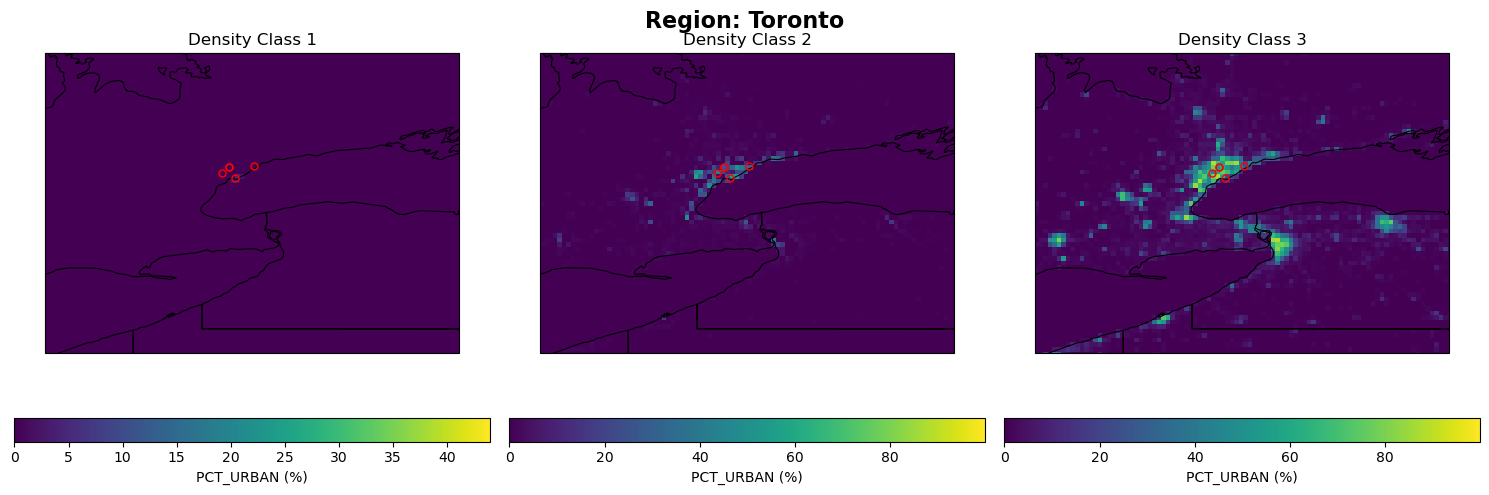

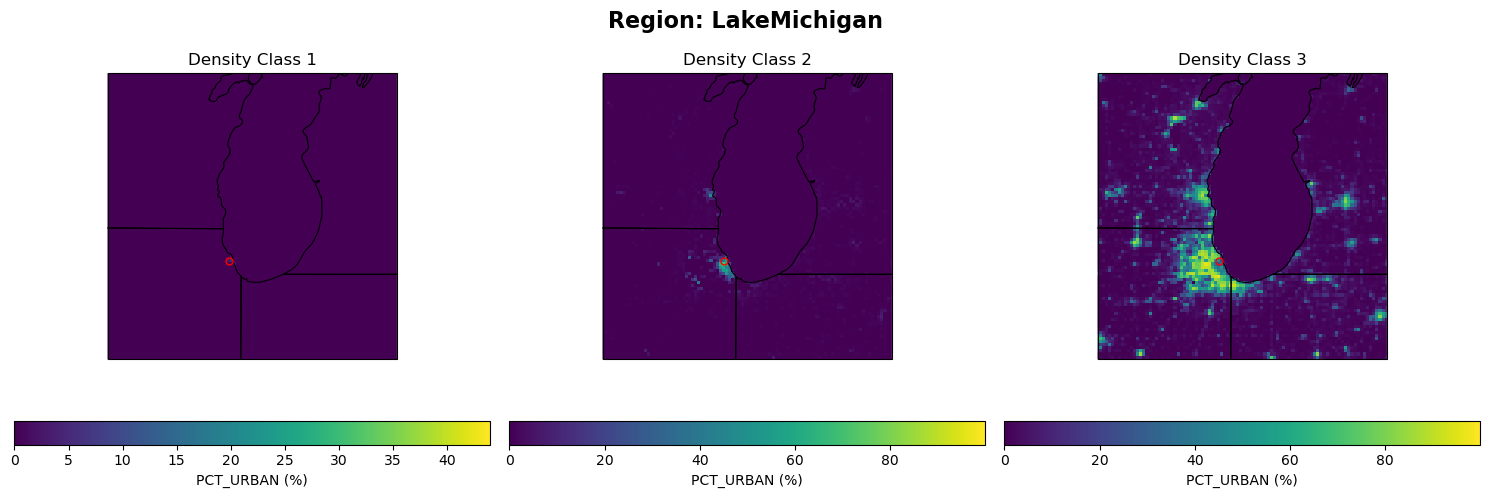

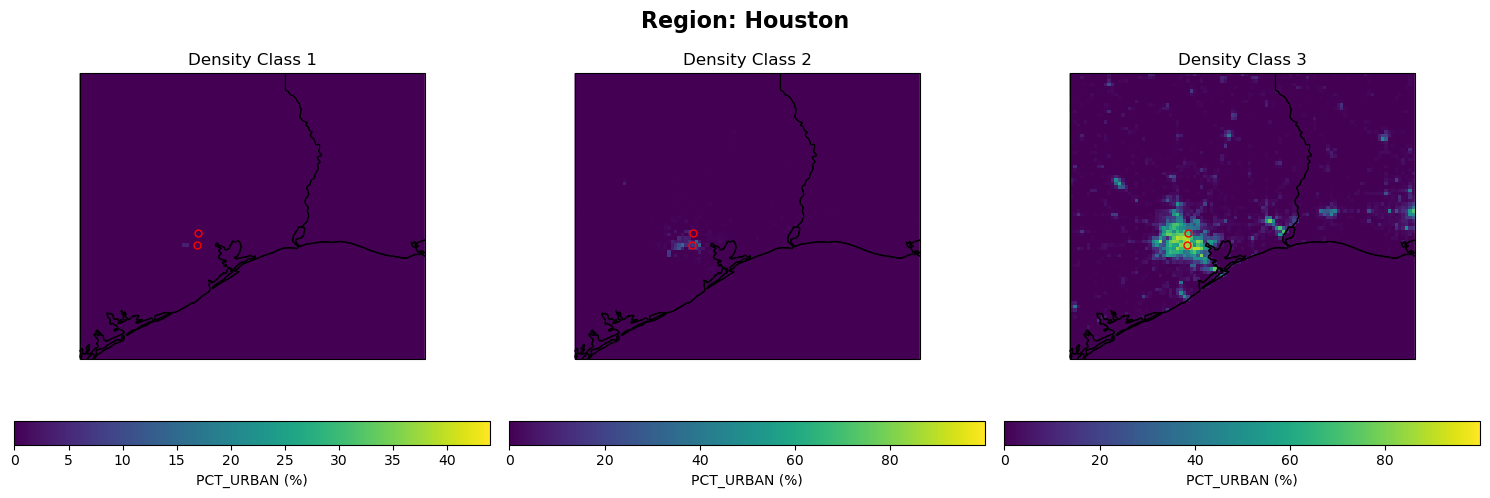

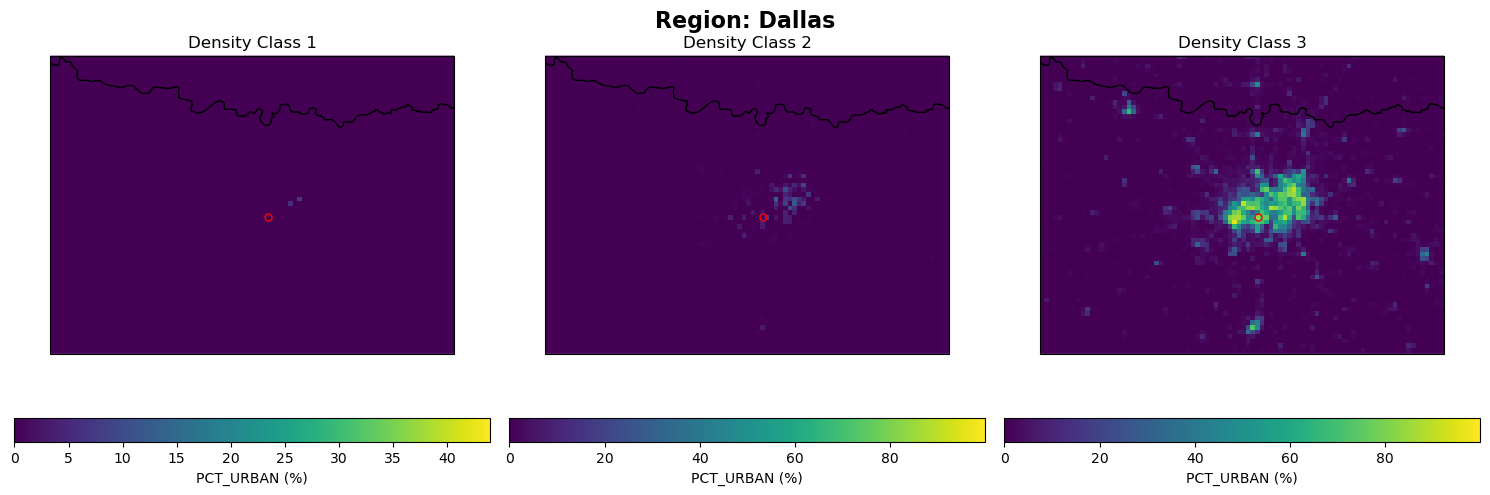

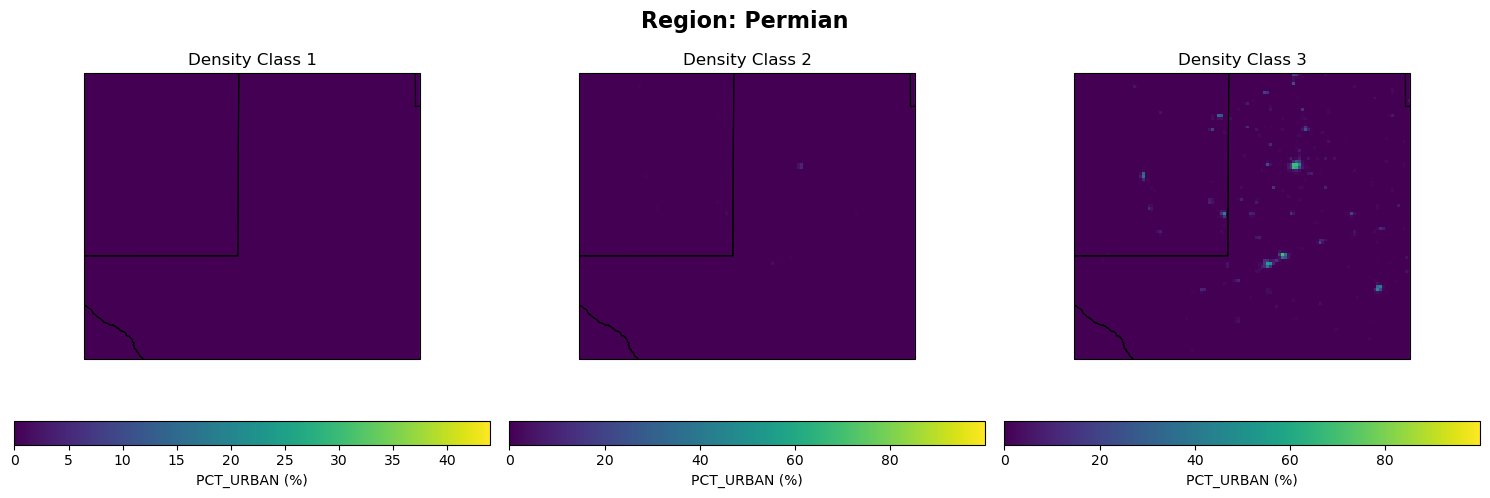

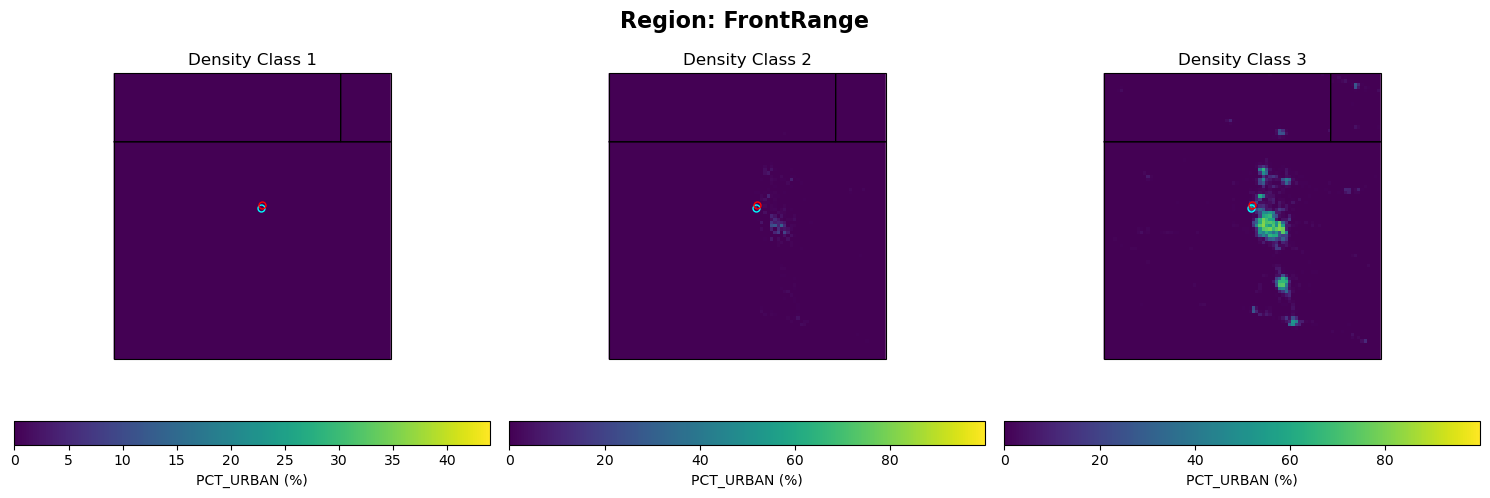

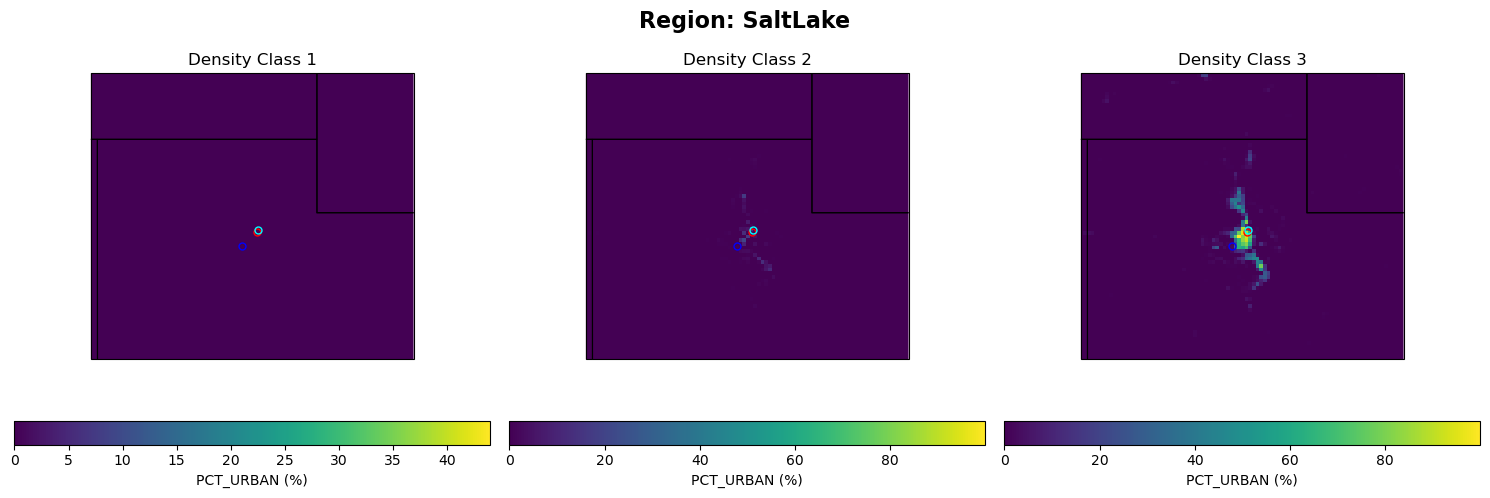

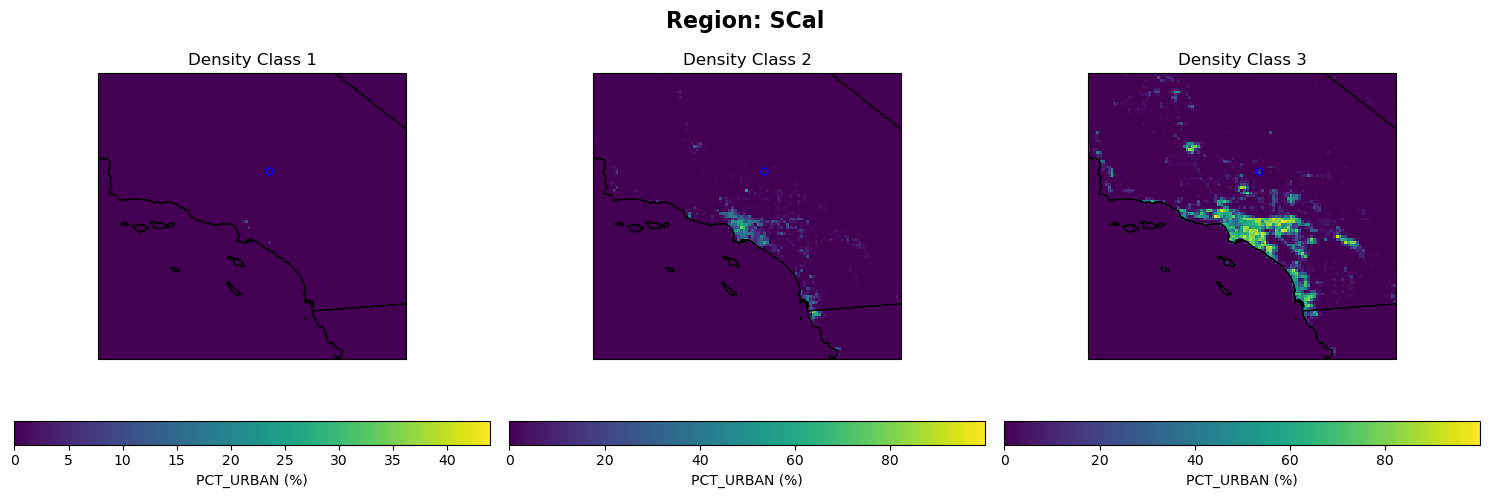

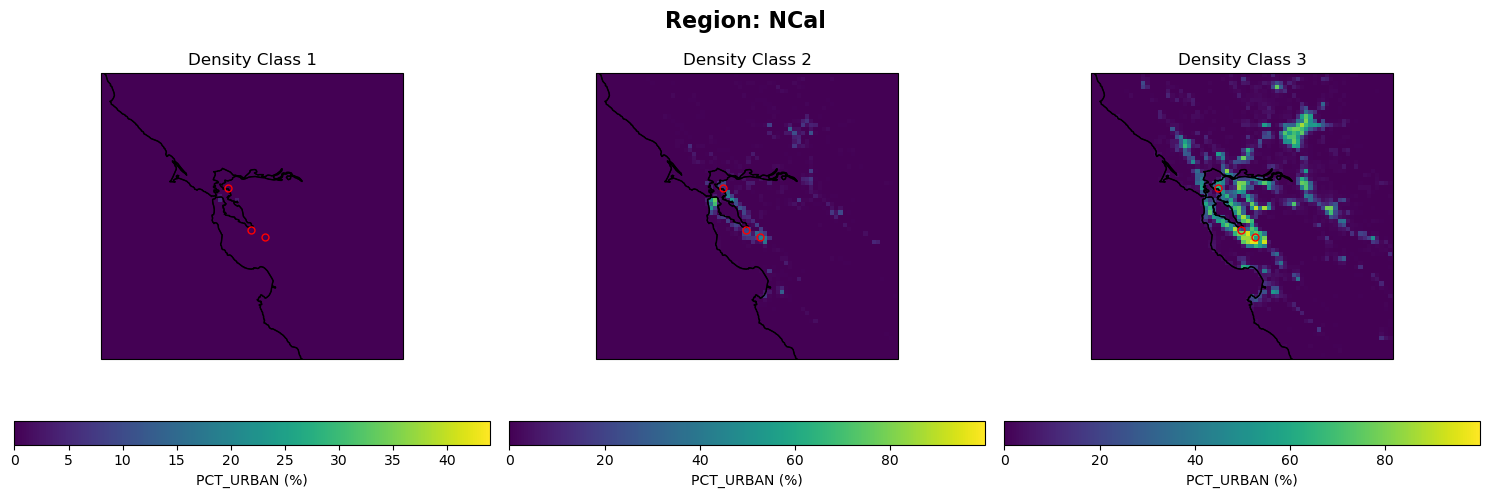

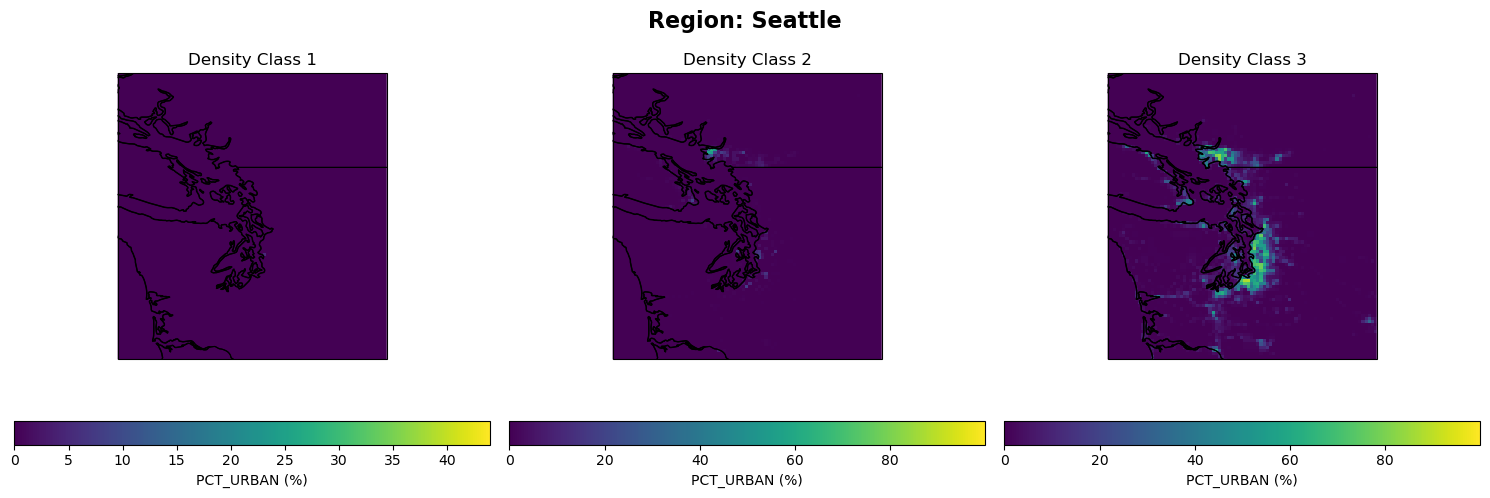

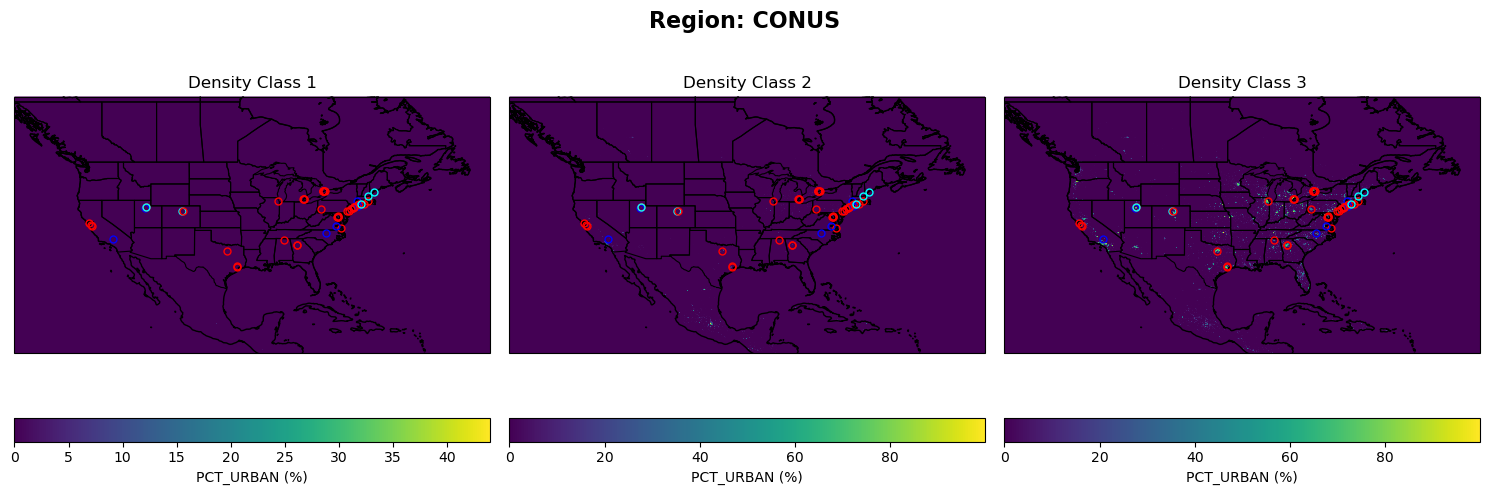

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


boxes = [
    {"min_lat": 38.397124, "max_lat": 43.055933, "min_lon": -77.343360, "max_lon": -69.603556, "region_name": "NW"},
    {"min_lat": 42.729102, "max_lat": 44.032715, "min_lon": -80.489687, "max_lon": -77.932344, "region_name": "Toronto"},
    {"min_lat": 41.387606, "max_lat": 43.995645, "min_lon": -88.671979, "max_lon": -86.012887, "region_name": "LakeMichigan"},
    {"min_lat": 29.051192, "max_lat": 31.236998, "min_lon": -96.054373, "max_lon": -93.004179, "region_name": "Houston"},
    {"min_lat": 32.235935, "max_lat": 33.486231, "min_lon": -98.492115 ,"max_lon": -96.088164, "region_name": "Dallas"},
    {"min_lat": 31.213267, "max_lat": 34.152176, "min_lon": -104.711041, "max_lon": -100.922105, "region_name": "Permian"},
    {"min_lat": 38.695336, "max_lat": 41.040847, "min_lon": -106.499399, "max_lon": -104.291528, "region_name": "FrontRange"},
    {"min_lat": 40.0, "max_lat": 41.900908, "min_lon": -113.131188, "max_lon": -110.733626, "region_name": "SaltLake"},
    {"min_lat": 32.691328, "max_lat": 35.649231, "min_lon": -119.834874, "max_lon": -116.503971, "region_name": "SCal"},
    {"min_lat": 36.866916, "max_lat": 38.291623, "min_lon": -122.850517, "max_lon": -121.231491, "region_name": "NCal"},
    {"min_lat": 46.982592, "max_lat": 49.468725, "min_lon": -123.627552, "max_lon": -121.409940, "region_name": "Seattle"},
    {"min_lat": 15, "max_lat": 60, "min_lon": -135, "max_lon": -50, "region_name": "CONUS"},
]


# Load dataset
landmask = '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rawdata/gao_oneill_urban/historical/urban_properties_GaoOneil_05deg_ThreeClass_2020_cdf5_c20220910.nc'
df = xr.open_dataset(landmask)

# Assign lat/lon
df['lat'] = df['LAT']
df['lon'] = df['LON']
lat = df['LAT']
lon = df['LON']
pct_urban = df['PCT_URBAN']


# Reduce resolution: Choose a downsampling factor (adjust for speed vs. detail)
stride = 1  # Pick every 10th grid point

lat_sub = lat[::stride]
lon_sub = lon[::stride]
pct_urban_sub = pct_urban[:, ::stride, ::stride]  # Subsample the urban percentage data

pandora_loc = pd.read_csv('/glade/work/maryamao/JEDI/pandora_coord_conus_urb.csv')
stn_lats = pandora_loc['lat'].values
stn_lons = pandora_loc['lon'].values
stn_names = pandora_loc['File']
stn_urbclass = pandora_loc['urb_class'].values

color_map = {1: 'blue', 2: 'cyan', 3: 'red'}

box_buffer = 1
for box in boxes:
    region_name = box["region_name"]
    extent = [box["min_lon"]-box_buffer, box["max_lon"]+box_buffer, box["min_lat"]-box_buffer, box["max_lat"]+box_buffer]
    
    # Define plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()})
    fig.suptitle(f"Region: {region_name}", fontsize=16, fontweight="bold")
    
    for i, ax in enumerate(axes):
        ax.set_title(f"Density Class {i+1}")
        
        # Use subsampled data for faster rendering
        img = ax.pcolormesh(lon_sub, lat_sub, pct_urban_sub[i, :, :], transform=ccrs.PlateCarree(), cmap="viridis")
        
        # Set CONUS zoom
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        
        ax.coastlines()
        ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.8)
    
        # Plot stations
        for lat, lon, urb_class in zip(stn_lats, stn_lons, stn_urbclass):
            if extent[0] <= lon <= extent[1] and extent[2] <= lat <= extent[3]:
                ax.plot(lon, lat, marker='o', markersize=5, markerfacecolor='none',
                    markeredgecolor=color_map[urb_class], label=f'Urb Class {urb_class}')        
        
        # Add colorbar
        fig.colorbar(img, ax=ax, orientation="horizontal", label="PCT_URBAN (%)")
    
    plt.tight_layout()
    plot_dir = "/glade/work/maryamao/JEDI/plots/"
    plot_name = f"map_density_class_pandora_{region_name}"
    plt.savefig(f"{plot_dir}{plot_name}",bbox_inches='tight',dpi=300)
    #plt.show()
